# Digital Trace Data - Lab 5: Digital Trace Data and AI

In this week's lab, we will explore how to apply machine learning (ML) techniques to digital trace data, focusing on text data.

This lab consists of two main parts:

1. Using a Machine Learning (ML) Model to Label Text
    In this step, we will use a Natural Language Processing model (like chatGPT) to automatically label or categorize comments from Reddit. Transformer models are particularly powerful for understanding the context of text due to their ability to capture long-range dependencies between words. Specifically, you will:
* Input digital trace text data into the transformer model: We will use pre-trained models that have been fine-tuned for specific tasks, such as sentiment analysis, topic categorization, or keyword extraction.
* Generate predictions: The model will assign labels to the text based on its training. These labels will indicate hate (hate, not hate) or sentiment (positive, negative, neutral).
       
2. Auditing the ML Model
    Auditing a machine learning model is crucial to ensuring that it is fair, transparent, and reliable. In this step, we will evaluate where the model perform better or worse depending on the gender of the user commentingo on Reddit.
        
By the end of the lab, you will have hands-on experience applying state-of-the-art AI models to digital trace data and conducting an  audit of their performance and fairness.

## Part 1: Labeling data - Example of Hate Speech

Hate speech is defined
as a "direct and serious attack on any protected category of people based on their
race, ethnicity, national origin, religion, sex, gender, sexual orientation, disability
or disease" [[ref]](https://ojs.aaai.org/index.php/ICWSM/article/view/150410).

In this part, we will analyze data from three subreddits and will try classifying their comments to check whether it is hate speech or not. The three subreddits are

- *dsa*: A subreddit dedicated to discussions related to the Democratic Socialists of America (DSA)
- *thenewright*: A subreddit centered around discussions of right-wing political ideologies
- *statistics*: A subreddit for discussions and questions related to the field of statistics


If you are interested in how we cleaned the data, this is [here](https://colab.research.google.com/github/digitalTraceData/digitalTraceData.github.io/blob/main/materials/lab5/lab5_clean_reddit_data.ipynb)

First, download the csv files for the three subreddits from the link on the blackboard

### 1.1 Open on of the csv files on your computer. Explain what the different variables (*author*, *body*, *controversiality*, *score*, and *created_utc*) mean? Which comment has the lowest/highest score?

Answer:

- *author*: Comment's author
- *body*: Text of the comment
- *controversiality*: Controversiality score (0 to 1)
- *score*: original score by reddit (-449 to 1.47*10^9)
- *created_utc*: Time & date of creation

Let's first load the files from these subreddits into Python. To do so, as done in the previous weeks, upload the files to Colab and replace the placeholders below by the actual paths.

In [ ]:
import pandas as pd
#
dsa = pd.read_csv("dsa.csv.gz", compression="gzip")
thenewright = pd.read_csv("thenewright.csv.gz", compression="gzip")
statistics = pd.read_csv("statistics.csv.gz", compression="gzip")


# Showing how the data looks like
dsa.head()

Next, we will use a machine learning model from [huggingface.co](https://huggingface.co/Hate-speech-CNERG/dehatebert-mono-english) to classify the content of the comments into hate-speech or non-hate-speech.

The code below first loads the pre-trained classification model from [huggingface.co](https://huggingface.co/Hate-speech-CNERG/dehatebert-mono-english) and then applies it to a sample of the data of a specified size (`sample_size` argument). The model requires the comments to be at most 512 characters, so we first truncate comments to their first 512 characters. The model provides a label (HATE/NON_HATE) and a probability of the label. We reverse the probability for the label NON_HATE so higher scores mean higher levels of hate.

In [24]:
from transformers import pipeline

# Create function to classify comments
def classify_comment(pipe, comments):
    # Truncate comments to first 512 characters to avoid error
    truncated_comments = [comment[:512] for comment in comments]
    results = pipe(truncated_comments)  # Process comments as a batch


    return [result["score"] if   result["label"] in {"HATE", "negative"}
                            else 1-result['score']
            for result in results]  # Extract labels

def label_data(data, sample_size=1000, model_name="Hate-speech-CNERG/dehatebert-mono-english", random_state=123, classify_comment=classify_comment):
  """
  Classifies comments in a DataFrame using a specified model.
  """
  # Load text classification pipeline with a model for hate speech detection
  pipe = pipeline("text-classification", model=model_name, device=0)

  # Draw a sample from non-deleted comments
  sample_data = data.sample(n=sample_size, replace=False, random_state=random_state)

  # Apply the classifier to the sampled comments
  sample_data['hate_score'] = classify_comment(pipe, sample_data['body'])

  return sample_data

### 1.2 Apply the `label_data` function to the data from the three subreddits using the defaults.

Name them `df_tnr_label`, `df_stats_label`, `df_dsa_label`.

The code is written below, you could increase teh sample_size but it will take a long time to run.


In [94]:
# Labeling the data
df_tnr_label = label_data(thenewright, model_name="Hate-speech-CNERG/dehatebert-mono-english")
df_stats_label = label_data(statistics, model_name="Hate-speech-CNERG/dehatebert-mono-english")
df_dsa_label = label_data(dsa, model_name="Hate-speech-CNERG/dehatebert-mono-english")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Showing how the labeled data looks like
df_tnr_label.head()

What is the comment with the highest hate score in each subreddit? (see code below for inspiration)

Answer:

**Statistics**
* 'You had me until Patriots. \n\nFuck the Pats, fuck Tom Brady, fuck Bill Belichick, go Mahomes',
* 'Statisticians are too good to mingle with the philistines in Machine Learning, hey',
* 'I really like the presentation, but I really want to slap to the idiot playing with the video camera.',

**DSA**
* 'Nah just rednecks who will never see a protest in their life are terrified. \n\nJust like they were terrified of Islamic extremists.',
* 'Wow. This is truly disgusting. Equating the victims of a campaign of genocide with the perpetrators. Idc what you think of Hamas - they are the vanguard of the Resistance in Palestine; they are the ones the Palestinians have chosen to fight for their liberation. As such, they deserve our unqualified support. Otherwise you are "both-sidesing" genocide.',
* 'Just blocked them. They’re all human filth so I’ll just keep convincing the people in my personal life to vot for Bernie instead. Thanks for the advice even though I knew this is what it would come to. My OCD makes it painful not to see new information',
       
**TNR**
* 'Fuck that faggot fredo. \n\n-an Italian',
* 'The one dude is now a professional builder or something, so yeah. This fat little lefty faggot is about 30-50 lbs overweight and living at home.',
* "Mexico deports illegal aliens, therefore, Mexicans are Nazis. The USA deports illegal aliens from Mexico, therefore Americans are Nazis. But wait, how can they be Nazis for deporting Nazis? Wouldn't America be less Nazi as a result of removing Nazis?\n\nDude's 'logic' isn't internally consistent, and it doesn't make any sense.",


In [27]:
df_tnr_label.sort_values(by="hate_score", ascending=False)["body"].head().values

array(['Fuck that faggot fredo. \n\n-an Italian',
       'The one dude is now a professional builder or something, so yeah. This fat little lefty faggot is about 30-50 lbs overweight and living at home.',
       "Mexico deports illegal aliens, therefore, Mexicans are Nazis. The USA deports illegal aliens from Mexico, therefore Americans are Nazis. But wait, how can they be Nazis for deporting Nazis? Wouldn't America be less Nazi as a result of removing Nazis?\n\nDude's 'logic' isn't internally consistent, and it doesn't make any sense.",
       "&gt;You don't downvote yet you just did it,\n\n[Nope. ](https://i.imgur.com/bJbAily.png) That's somebody else who thinks you're being a fag, too. I don't downvote because karma is something only faggots care about. That's why you care so kucn right now.\n\n&gt;Don't flatter yourself. It's apparent that any topic you can't defend is unimportant.\n\nImagine caring this much about the opinions of strangers on the internet. You should go outside.",

We can now analyze the provided hat_scores to the subreddits by plotting them.

What do the distributions tell you abuot the amount of hate in those platforms?

Answer: hate scores are the lowest in the Statistics subreddit with most of the density being close to zero. DSA and TheNewRight both have more density mass at higher hate scores but also the majority is low. TNR is slightly higher than DSA.

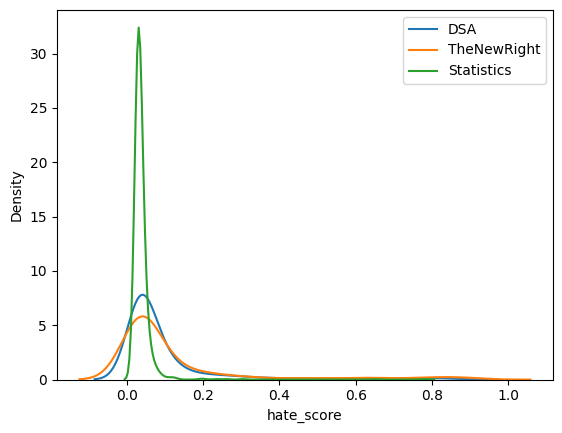

In [28]:
import seaborn as sns
import pylab as plt

sns.kdeplot(df_dsa_label["hate_score"], label="DSA")
sns.kdeplot(df_tnr_label["hate_score"], label="TheNewRight")
sns.kdeplot(df_stats_label["hate_score"], label="Statistics")
plt.legend()


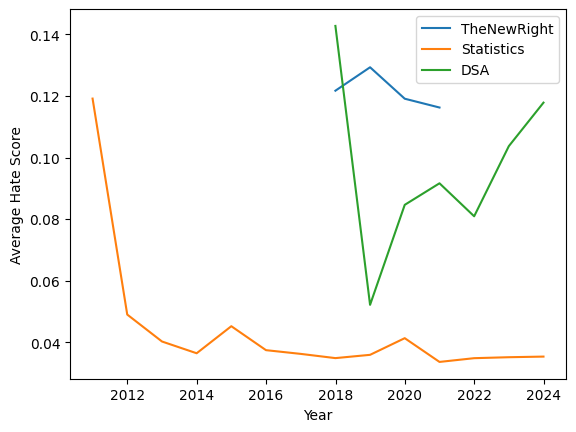

In [29]:
## TODO: Add confidence intervals (sns.pointplot)

# Convert 'created_utc' to datetime objects
df_tnr_label["created_utc"] = pd.to_datetime(df_tnr_label["created_utc"], unit="s")
df_stats_label["created_utc"] = pd.to_datetime(df_stats_label["created_utc"], unit="s")
df_dsa_label["created_utc"] = pd.to_datetime(df_dsa_label["created_utc"], unit="s")

# Group each subreddit's data by year and calculate mean hate score.
tnr_avg_hate = df_tnr_label.groupby(pd.Grouper(key="created_utc", freq="YE"))["hate_score"].mean()
stats_avg_hate = df_stats_label.groupby(pd.Grouper(key="created_utc", freq="YE"))["hate_score"].mean()
dsa_avg_hate = df_dsa_label.groupby(pd.Grouper(key="created_utc", freq="YE"))["hate_score"].mean()

# Plot average hate score over time by subreddit
plt.plot(tnr_avg_hate.index, tnr_avg_hate.values, label="TheNewRight")
plt.plot(stats_avg_hate.index, stats_avg_hate.values, label="Statistics")
plt.plot(dsa_avg_hate.index, dsa_avg_hate.values, label="DSA")

plt.xlabel("Year")
plt.ylabel('Average Hate Score')
plt.legend()
plt.show()


### 1.3 What is the approximate share of hate speech per subreddit according to the model?

Answer:

- TNR: 12.3%
- DSA: 9.5%
- Stats: 3.8%



### 1.4 Can you find an example labeled as hate speech that is likely not hate speech?  What do you think went wrong?

In [ ]:
df_dsa_label.sort_values(by='hate_score', ascending=False)['body'].iloc[4]

Answer:

For example: "I agree, I think a lot of these people challenging actual leftists in Congress, be it in the Democratic primary or in the general election as a Republican, are doing it largely so that they can grift people to donate to them to stop these "far-left extremists"."

It may be classified as hate speech because of the word "leftist", which may be used in a derogatory manner in the training dataset.

### 1.5 For each subreddit, what is the correlation between `score` (as calculated in Reddit) and `hate_score` (the probability of a comment being hate speech, as inferred from the ML model).


In [ ]:
# Answer

print(df_dsa_label['score'].corr(df_dsa_label['hate_score']))
print(df_tnr_label['score'].corr(df_tnr_label['hate_score']))
print(df_stats_label['score'].corr(df_stats_label['hate_score']))

### 1.6 Now re-run the `label_data` function using [this](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) sentiment model (Hint: You can do this by setting `model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"` in the `label_data` function). What are the most negative comments? What are the most negative subreddits?

In [ ]:
# Labeling the data (code to be completed)
df_tnr_label_sent = label_data(thenewright, model_name="cardiffnlp/twitter-roberta-base-sentiment-latest")
df_dsa_label_sent = label_data(dsa, model_name="cardiffnlp/twitter-roberta-base-sentiment-latest")
df_stats_label_sent = label_data(statistics, model_name="cardiffnlp/twitter-roberta-base-sentiment-latest")

Answer:

**TheNewRight**
* 'FRY HER. She is perhaps the worst of them all because she COMPLETELY abrogated her duty as AG. Cankled scumbag.'
* 'No its ridiculous at the airport even more ridiculous when its refugees. You soulless pieces of shit.'
* 'That cretin is white as well, the fuck is wrong with these people? Has he ever tried taking a stroll in the hood with that stupid face, to see what his beloved poc do to dumb virtue signalers like him? '
 
**DSA**
* 'What a fucking coward fake pos u/magictheblathering is. Dude not only blocked me but sent the reddit suicide crisis to me after wishing for my death. Most sane “leftist”'
* 'What a spineless, dishonest, embarrassing twist of a response. On the topic of a fucking genocide. You should be ashamed.'
* 'you weird debate lord i do not give a shit about this stupid dsasubreddit, i care about the brown kids see dying every day. i didnt vote for him the first time either lmao'
 
**Statistics**
* "UGH - don't take this or anything at this university!!!"
* 'Or put one of them in the sidebar? Reddit has a notoriously shitty search feature. '
* 'Paywalls suck. Best of luck getting those articles, and mad respect for studying on the side!'
 
**Average hate score for each subreddit**

TheNewRight: 0.54
DSA: 0.53
Statistics: 0.36

--> TNR is slightly more negative than DSA


### 1.7 For each subreddit, what is the correlation between `score` (as calculated in Reddit) and `hate_score` (the probability of a comment being negative, as inferred from the ML model)

In [ ]:
# Answer

print(df_dsa_label_sent['score'].corr(df_dsa_label_sent['hate_score']))
print(df_tnr_label_sent['score'].corr(df_tnr_label_sent['hate_score']))
print(df_stats_label_sent['score'].corr(df_stats_label_sent['hate_score']))

The correlation between sentiment score and hate score is quite low
DSA: 4.9%
TNR: 4.2%
Statistics: -1.1%

0.04862445206002881

0.042367784637324

-0.010501423694899387

## Part 2: Reflection on AI Biases

### Data Collection and Annotation Bias

The hate speech model you used was trained using mostly data from Twitter and Stormfront (a neo-nazi forum) [[original source]](https://arxiv.org/pdf/2004.06465).



#### 2.1 Sample bias: to what extent is the data used in the training of the model representative of the Reddit data you are using? What are the potential implications for the analysis?

Answer:

The model was trained on Twitter and Stormfront data. This is most likely not representative of Reddit data, especially the Statistics (very nerdy) and DSA (left wing). 

The model will not be able to perform well for subpopulations that were not present in the training data. For example, it may overestimate the hate speech with terms used in Twitter/Stormfront in a derogatory context, such as "lefties". 

#### 2.2 How could outcome bias (label bias) be affecting this model? (remember that the model was trained using several datasets from different sources and annotated in different ways).

Answer:

Different datasets/papers use different definitions of hate speech. If the definition of hate speech is different for the data on Stormfront and the data on Twitter, this could create different meanings for the outcome variable (the label) for different subpopulations.

#### 2.3 If you use this model to label data and answer a research question, what type of measurment error would you be including?

You will be introducing processing error. 

### Part 3: Auditing and correcting models:

We have now added three new columns: `gender` (male/female/queer/neutral), `label_value` (the "true" label of hate) and `score` (the label of hate predicted by the previous model, where a score greater than 0.5 is considered hate). Assume the `gender` and `label_value` columns have no mistakes for the sake of the exercise.

Download the data set `df_dsa_label_true.csv` with these columns from the link above and upload them into Colab. Then load it into Python with the code below:

In [101]:
# Load artificially labelled dsa comments
import pandas as pd
df_dsa_label_true = pd.read_csv("df_dsa_label_true.csv.gz", compression="gzip",index_col=0)
df_dsa_label_true.head()

,score,label_value,gender,text
10760,False,False,other,Actually that is not a critique of UBI / GBI f...
33116,False,True,female,Suggest about what? This is just sensationaliz...
35607,False,False,other,"Ignore the individual, look for the consequenc..."
46232,False,False,other,Does anyone remember the last name of Mike the...
26892,False,False,male,and actually I don't even think it's in the gr...


### 3.1 Based on the confusion matrix below (columns = predicted by algorithm; row = true values). Is the model good?

Answer: Not really, quite a few comments were falsely labelled as non-hate-speech even though they are (in reality) hate speech



In [130]:
print("All groups")
pd.crosstab(df_dsa_label_true["label_value"], df_dsa_label_true["score"])


All groups


score,False,True
label_value,,
False,798,13
True,167,22


### 3.2 Based on the confusion matrixes below per group
* What group has a higher false positive rate (false positives / negatives)?

*male* has the highest false-positive rate (0.019 = 3/(3+153)).

* What group has a higher false negative rate (false negative / positives)?

*female* has the highest false-negative rate (0.24 = 5/(5+16)).

In [131]:
for group, df_group in df_dsa_label_true.groupby("gender"):
  print(group)
  display(pd.crosstab(df_group["label_value"], df_group["score"]))

female


score,False
label_value,
False,16
True,5


male


score,False,True
label_value,,
False,153,3
True,33,5


other


score,False,True
label_value,,
False,496,9
True,98,12


queer


score,False,True
label_value,,
False,133,1
True,31,5


Next, we can use the `aequitas` package to audit the model. First read what `aequitas` does [on their website](https://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/)

In [104]:
!pip install aequitas &> /dev/null # install aequitas
from aequitas.audit import Audit # load it

In [109]:
# Audit model
audit = Audit(df_dsa_label_true.drop(columns=["text"]),
              label_column="label_value")
audit.audit()


Here is an example of how to audit a model using "FPR" (predictive equality) as a measure of bias.

Some metrics available:
* False Positive Rate (fpr) -- predictive equality
* False Discovery Rate (fdr),
* False Omission Rate (for),
* False Negative Rate (fnr),
* Demographic parity (pprev),
* Equal opportunity (tpr)

In [132]:
metrics = ["fpr"] # specify metrics

disparity_tolerance = 1.25 # specify tolerance thresholds (at most 25% disparity)
audit.summary_plot(metrics=metrics, fairness_threshold=disparity_tolerance) # plot metrics with specified thresholds

alt.VConcatChart(...)

In [112]:
audit.disparity_plot(attribute="gender", metrics=["for"])

alt.LayerChart(...)

### 3.3 Imagine you are using the ML model for an assistive intervention: you want to detect hate speech and offer extra holidays and mental health resources to those people. Which metric would you use to assess fairness?

Hint: see the [decision tree](https://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/).

Answer: The intervention is assisitive.

The answer depends on your ability to provide mental health resources to people. 
* If you are able to intervene most people --> False negative rate parity (you don't want to exclude people in need)
* If you are able to intervene few people --> True positive rate parity (you don't want to give precious resources to people not in need)



### 3.4 Imagine you are using the ML model for a punitive intervention: you want to detect hate speech and fine those people. Which metric would you use to assess fairness?

Hint: see the [decision tree](https://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/).

Answer: The intervention is punitive.

The answer is False positive rate parity (you don't want to punish innocent people)


*ADD ANSWER HERE*

### 3.5. What information do you need to be able to correct your model? Do you have that information in your group project?
*ADD YOUR ANSWER HERE*


Answer: You need the "true data" and the data on the sensitive attributes (e.g. gender, race). You likely do not have that information in your project.


### Are you still interested in how to audit and correct models?
Take a look at the notebooks of `aequitas` on how to audit and train models: https://github.com/dssg/aequitas?tab=readme-ov-file